In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import quantities as pq
from operator import itemgetter
from edog.tools import*
from edog.plot import*
plt.style.use('seaborn')
plt.rcParams.update(edog.plot.params)

stim_filename = "cat.gif"
filename = "params.yaml"
params = parse_parameters(filename)

nt, nr, dt, dr = itemgetter("nt", "nr", "dt", "dr")(params["grid"])

A_g, a_g, B_g, b_g = itemgetter("A", "a", "B", "b")(params["ganglion"])
phase, damping, delay_g = itemgetter("phase", "damping", "delay")(params["ganglion"])

w_rg, A_rg, a_rg = itemgetter("w", "A", "a")(params["relay"]["Krg"])
tau_rg, delay_rg = itemgetter("tau", "delay")(params["relay"]["Krg"])

w_rig, A_rig, a_rig = itemgetter("w", "A", "a")(params["relay"]["Krig"])
tau_rig, delay_rig = itemgetter("tau", "delay")(params["relay"]["Krig"])

w_rig, A_rig, a_rig = itemgetter("w", "A", "a")(params["relay"]["Krig"])
tau_rig, delay_rig = itemgetter("tau", "delay")(params["relay"]["Krig"])

w_rc_mix = itemgetter("w")(params["relay"]["Krc_mix"])
A_rc_in, a_rc_in = itemgetter("A", "a")(params["relay"]["Krc_mix"]["Krc_in"])
A_rc_ex, a_rc_ex = itemgetter("A", "a")(params["relay"]["Krc_mix"]["Krc_ex"])

delayed_in, synced, delayed_ex = itemgetter("delayed_in", "synced", "delayed_ex")(params["relay"]["Krc_mix"])

## Settings

In [2]:
cmap = "gray"
interpolation = "none"
titles = ["delayed inhibition", "synced feedback", "delayed excitation"]

shift = 40
alpha = 0.15
fig = plt.figure(figsize=(8, 4.0))
gs1 = gridspec.GridSpec(6, 6)
gs1.update(bottom=0.15)

gs2 = gridspec.GridSpec(6, 6)
gs2.update(left=0.1, right=0.98, hspace=1.5, wspace=0.2)


ax = plt.subplot(gs1[:, :3])
axarr = []
axarr.append(plt.subplot(gs2[:2, 3:4]))
axarr.append(plt.subplot(gs2[:2, 4:5]))
axarr.append(plt.subplot(gs2[:2, 5:6]))
axarr.append(plt.subplot(gs2[2:4, 3:4]))
axarr.append(plt.subplot(gs2[2:4, 4:5]))
axarr.append(plt.subplot(gs2[2:4, 5:6]))
axarr.append(plt.subplot(gs2[4:, 3:4]))
axarr.append(plt.subplot(gs2[4:, 4:5]))
axarr.append(plt.subplot(gs2[4:, 5:6]))

plt.close()

## Autocorrelation for stimulus and relay cell response without feedback

In [3]:
stimulus = pylgn.stimulus.create_natural_movie(filename=stim_filename)
network = create_spatiotemporal_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                        A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                        phase=phase, damping=damping, delay_g=delay_g,
                                        w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                        tau_rg=tau_rg, delay_rg=delay_rg,
                                        w_rig=w_rig, A_rig=A_rig, a_rig=a_rig,
                                        tau_rig=tau_rig, delay_rig=delay_rig)

Nt, Nr = network.integrator.Nt, network.integrator.Nr
t, y, x = network.integrator.meshgrid()
times = network.integrator.times.rescale("s")

idxs = np.arange(int(Nr/2 - shift), int(Nr/2 + shift), 1, dtype=int)
idys = np.arange(int(Nr/2 - shift), int(Nr/2 + shift), 1, dtype=int)

network.set_stimulus(stimulus, compute_fft=True)
stim_data = stimulus(t, x, y)

[relay] = get_neuron("Relay", network)
network.compute_response(relay)

pixel_count = (len(idxs)*len(idys))
stim_corr = np.zeros([pixel_count, Nt])
corr = np.zeros([pixel_count, Nt]) * pq.s

k = 0
for idx in idxs:
    for idy in idys:
        response = relay.response[:, idx, idy]
        stim = stim_data[:, idx, idy]

        corr[k, :] = compute_autocorrelation(response)
        stim_corr[k, :] = compute_autocorrelation(stim)
        k += 1

stim_corr_mean = np.mean(stim_corr, axis=0)
stim_corr_std = np.std(stim_corr, axis=0)

corr_mean = np.mean(corr, axis=0)
corr_std = np.std(corr, axis=0)

ax.plot(times, stim_corr_mean, 'k', label="stimulus")
ax.fill_between(times, stim_corr_mean+stim_corr_std, stim_corr_mean-stim_corr_std, color="k", alpha=alpha)

ax.plot(times, corr_mean, ':k', label="no fb")
ax.fill_between(times, corr_mean+corr_std, corr_mean-corr_std, color="k", alpha=alpha)

## Autocorrelation for relay cell response with mixed excitatory and inhibitory feedback

In [4]:
for title, params in zip(titles, [delayed_in, synced, delayed_ex]):
    network = create_spatiotemporal_network(nt=nt, nr=nr, dt=dt, dr=dr,
                                            A_g=A_g, a_g=a_g, B_g=B_g, b_g=b_g,
                                            phase=phase, damping=damping, delay_g=delay_g,
                                            w_rg=w_rg, A_rg=A_rg, a_rg=a_rg,
                                            tau_rg=tau_rg, delay_rg=delay_rg,
                                            w_rig=w_rig, A_rig=A_rig, a_rig=a_rig,
                                            tau_rig=tau_rig, delay_rig=delay_rig,
                                            w_rc_ex=w_rc_mix, A_rc_ex=A_rc_ex, a_rc_ex=a_rc_ex,
                                            tau_rc_ex=params["tau_ex"], delay_rc_ex=params["delay_ex"],
                                            w_rc_in=w_rc_mix, A_rc_in=A_rc_in, a_rc_in=a_rc_in,
                                            tau_rc_in=params["tau_in"], delay_rc_in=params["delay_in"])

    network.set_stimulus(stimulus, compute_fft=True)
    [relay] = get_neuron("Relay", network)
    network.compute_response(relay)

    corr = np.zeros([pixel_count, Nt]) * pq.s

    k = 0
    for idx in idxs:
        for idy in idys:
            response = relay.response[:, idx, idy]
            corr[k, :] = compute_autocorrelation(response)
            k += 1

    corr_mean = np.mean(corr, axis=0)
    corr_std = np.std(corr, axis=0)

    ax.plot(times, corr_mean, label=title)
    ax.fill_between(times, corr_mean+corr_std, corr_mean-corr_std, alpha=alpha)
    
    
ax.legend(fontsize=14, handlelength=0.5, labelspacing=0.2, borderpad=0.0)
ax.set_xlabel("Time lag (s)")
ax.set_ylabel('Autocorrelation')
ax.set_xlim([0, 0.5])
ax.set_ylim([-0.2, 1.0])

(-0.2, 1.0)

## Movie sequences

In [5]:
positions = network.integrator.positions
extent = [positions.min(), positions.max(), positions.min(), positions.max()]
Nr = network.integrator.Nr
ids = range(0, 2000, 200)

for idx, ax in zip(ids, axarr):
    im = ax.imshow(stim_data[idx, :, :], cmap=cmap, interpolation=interpolation, extent=extent,
                   aspect="auto", origin="lower")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)
    ax.set_title("$t={}\;\mathrm{{s}}$".format(round(times[idx].rescale("s"), 1).magnitude))

    circ = plt.Circle((0, 0), 1.6/2, fill=False, edgecolor="#de2d26", linewidth=2, linestyle="-")
    ax.add_artist(circ)

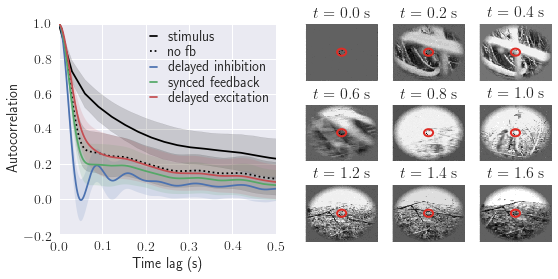

In [6]:
fig